In [8]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import os
# os.chdir("../../pykan/kan/")
from Scaled_KAN import *

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size_train = 32
batch_size_test = 32
lr = 1e-3
momentum = 0.8

tasks = 10

In [17]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NN()
model.to(device)
    
KAN_model = FastKAN(layers_hidden=[28*28,64,10], grid_min=3, grid_max=5, device=device)
KAN_model.to(device)

print(f"Conventional model: {model}")
print(f"KAN model: {KAN_model}")

Conventional model: NN(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
KAN model: FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=6272, out_features=64, bias=False)
      (base_linear): Linear(in_features=784, out_features=64, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=512, out_features=10, bias=False)
      (base_linear): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)


In [10]:
import numpy as np

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307),(0.3081)),
    T.Lambda(lambda x: torch.flatten(x))
])
train_set = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('../data', train=False, download=True, transform=transform)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=momentum)

loss_fn = nn.CrossEntropyLoss()

tasks = [(i,i+1) for i in range(0,10,2)]

targets = train_set.targets.numpy()
splitted_train = []
for task in tasks:
    indices = np.where(np.isin(targets, task))[0]
    subset = [train_set[i] for i in indices]
    splitted_train.append(subset)

targets = test_set.targets.numpy()
splitted_test = []
for task in tasks:
    indices = np.where(np.isin(targets, task))[0]
    subset = [test_set[i] for i in indices]
    splitted_test.append(subset)

performance = []
for task in range(len(tasks)-1,0,-1):
    print(f"Training on {task}")
    train_loader = torch.utils.data.DataLoader(
        splitted_train[task],
        batch_size=batch_size_train,
        shuffle=True
    )
    performance.extend(splitted_train[task])
    
    test_loader = torch.utils.data.DataLoader(
        performance, 
        batch_size=batch_size_test, 
        shuffle=True
    )
    # rand_image = random.choice(performance)
    # print(rand_image[0][0].shape)
    # plt.imshow(rand_image[0][0].numpy().reshape(28,28))
    # plt.show()
    
    
    print(len(train_loader.dataset), len(test_loader.dataset))
    for epoch in range(10):
        # Train the model
        model.train()
        train_loss = 0
        correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            output = F.softmax(output, dim=1)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss /= len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        with torch.no_grad():
            model.eval()
            test_loss = 0
            correct = 0
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                output = F.softmax(output, dim=1)
                test_loss += loss_fn(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
            test_loss /= len(test_loader.dataset)
            test_acc = correct / len(test_loader.dataset)

        # Update the learning rate
        scheduler.step()
        print(f'Epoch {epoch+1} train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

torch.save(model.state_dict(), "mnist_model.pth")

Training on 4
11800 11800
Epoch 1 train/test accuracy: 0.97/0.98
Epoch 2 train/test accuracy: 0.98/0.98
Epoch 3 train/test accuracy: 0.99/0.99
Epoch 4 train/test accuracy: 0.99/0.99
Epoch 5 train/test accuracy: 0.99/0.99
Epoch 6 train/test accuracy: 0.99/1.00
Epoch 7 train/test accuracy: 1.00/1.00
Epoch 8 train/test accuracy: 1.00/1.00
Epoch 9 train/test accuracy: 1.00/1.00
Epoch 10 train/test accuracy: 1.00/1.00
Training on 3
12183 23983
Epoch 1 train/test accuracy: 0.22/0.53
Epoch 2 train/test accuracy: 1.00/0.51
Epoch 3 train/test accuracy: 1.00/0.51
Epoch 4 train/test accuracy: 1.00/0.51
Epoch 5 train/test accuracy: 1.00/0.51
Epoch 6 train/test accuracy: 1.00/0.51
Epoch 7 train/test accuracy: 1.00/0.51
Epoch 8 train/test accuracy: 1.00/0.51
Epoch 9 train/test accuracy: 1.00/0.51
Epoch 10 train/test accuracy: 1.00/0.51
Training on 2
11263 35246
Epoch 1 train/test accuracy: 0.00/0.35
Epoch 2 train/test accuracy: 0.00/0.35
Epoch 3 train/test accuracy: 0.00/0.35
Epoch 4 train/test accu

In [14]:
model = FastKAN(layers_hidden=[28*28,64,10], grid_min=3, grid_max=5, device=device)
model.load_state_dict(torch.load("mnist_model.pth"))
model.to(device)
model.eval()

FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=6272, out_features=64, bias=False)
      (base_linear): Linear(in_features=784, out_features=64, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=512, out_features=10, bias=False)
      (base_linear): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)

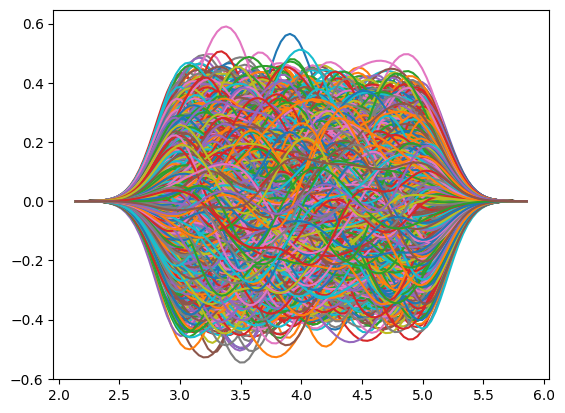

In [15]:
layers = []
for layer in model.modules():
    layers.append(layer)

layer = layers[2]
for i in range(layer.input_dim):
    for j in range(layer.output_dim):
        # layer.set_curve(i, j, torch.tensor([0.0, 1.0, 0.0], device=device))
        x, y = layer.plot_curve(i, j, num_pts=100, num_extrapolate_bins=3)
        plt.plot(x.to('cpu').numpy(), y.to('cpu').numpy(), label=f"Last Layer, Input {i}, Output {j}")
# plt.legend()
plt.show()

In [8]:
# for each pixel of the given input image, given a layer an input and an output, give me the gradient of the weights
def get_gradient(model, layer, input, output):
    model.zero_grad()
    output = model(input)
    output = F.softmax(output, dim=1)
    loss = F.cross_entropy(output, output)
    loss.backward()
    return layer.weight.grad

AttributeError: 'FastKANLayer' object has no attribute 'curve'